# モデルの学習

In [1]:
# import libraries

import numpy as np
import pandas as pd
import gc
import os
import json
from collections import Counter, defaultdict
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import plotly.express as px
import re
import datetime as dt
import japanize_matplotlib
import itertools
year_pattern = r'([1-2][0-9]{3})'
import time

In [2]:
DATAPATH = "../../../data/DBLP/made/"
OUTPUTPATH = "../../../result/aminer/"

In [3]:
with open(DATAPATH + "keywords_delete_similar_words.txt") as f:
    keywords = list(map(lambda x: x.replace("\n", ""), f.readlines()))
key_sets = set(keywords)
len(keywords), keywords[0]

(2275, '3d imaging')

In [4]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn import utils

from scipy.stats import pearsonr

In [5]:
train_x = np.load(DATAPATH + "train_x.npy")
train_y = np.load(DATAPATH + "train_y.npy")

test_x = np.load(DATAPATH + "test_x.npy")
test_y = np.load(DATAPATH + "test_y.npy")
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((2275, 2275, 23), (2275, 2275), (2275, 2275, 23), (2275, 2275))

In [6]:
N = train_x.shape[0]
M = train_x.shape[2]
N, M

(2275, 23)

In [7]:
train_x, train_y, test_x, test_y = train_x[np.triu_indices(n=N, k=1)], train_y[np.triu_indices(n=N, k=1)], test_x[np.triu_indices(n=N, k=1)], test_y[np.triu_indices(n=N, k=1)]
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((2586675, 23), (2586675,), (2586675, 23), (2586675,))

In [8]:
P = train_x.shape[0]
P

2586675

In [9]:
model = MLPRegressor()
start_time = time.perf_counter()
model.fit(train_x, train_y)
print("フィッティング時間: {}".format(time.perf_counter() - start_time))
start_time = time.perf_counter()
model.score(test_x, test_y)
print("スコア時間: {}".format(time.perf_counter() - start_time))

フィッティング時間: 714.3359811306
スコア時間: 2.7017639838159084


In [10]:
result = model.predict(test_x)
result_before = model.predict(train_x)
result.shape, result_before.shape

((2586675,), (2586675,))

In [11]:
print("RMSE: {}, MSE: {}, 相関係数: {}".format(
    round(np.sqrt(mean_squared_error(result_before, train_y)),3), 
    round(mean_squared_error(result_before, train_y),3),
    round(pearsonr(result_before, train_y)[0],3)))

RMSE: 10.378, MSE: 107.696, 相関係数: 0.843


In [12]:
print("RMSE: {}, MSE: {}, 相関係数: {}".format(
    round(np.sqrt(mean_squared_error(result, test_y)),3), 
    round(mean_squared_error(result, test_y),3),
    round(pearsonr(result, test_y)[0],3)))

RMSE: 6.331, MSE: 40.076, 相関係数: 0.45


In [13]:
df = pd.DataFrame(result, columns=["予測"])
df["実測"] = test_y
df["予測順位"] = df["予測"].rank(ascending=False)
df["実測順位"] = df["実測"].rank(ascending=False)
df = df.sort_values("予測順位", )
top = df.head(100)
len(top[top["実測順位"]<100]) / len(top)

0.31

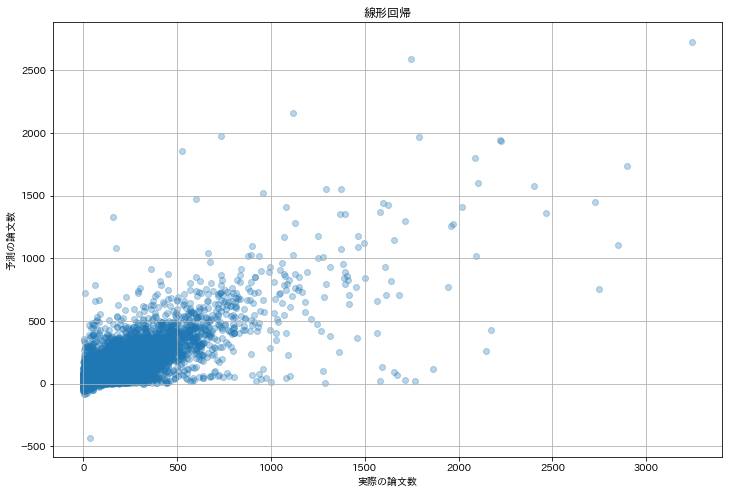

In [14]:
fig, ax = plt.subplots(facecolor="white",figsize=(12,8))
ax.scatter(train_y, result_before, alpha=0.3)
ax.set_xlabel("実際の論文数")
ax.set_ylabel("予測の論文数")
ax.grid()
ax.set_title("線形回帰")
fig.show()

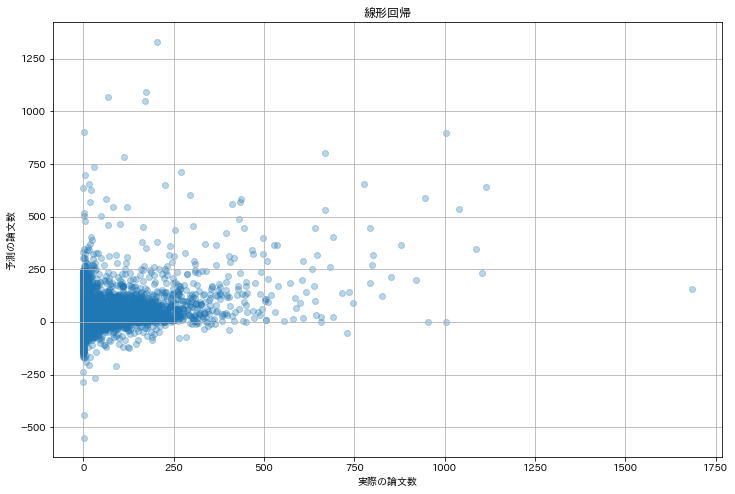

In [15]:
fig, ax = plt.subplots(facecolor="white",figsize=(12,8))
ax.scatter(test_y, result, alpha=0.3)
ax.set_xlabel("実際の論文数")
ax.set_ylabel("予測の論文数")
ax.grid()
ax.set_title("線形回帰")
fig.savefig(OUTPUTPATH+"img/lr.png")
fig.show()

In [16]:
predict_matrix = np.zeros([N,N]) 
correct_matrix = np.zeros([N,N]) 
correct_matrix[np.triu_indices(n=N, k=1)] = test_y
predict_matrix[np.triu_indices(n=N, k=1)] = model.predict(test_x)
for i in range(N):
    for j in range(N):
        if predict_matrix[i][j] > 400:
            print("キーワード: {}, {}, 予測値: {}, 実測値: {}".format(keywords[i], keywords[j],round(predict_matrix[i][j],1), correct_matrix[i][j]))

キーワード: algorithm, design, 予測値: 1048.0, 実測値: 171.0
キーワード: algorithm, experimentation, 予測値: 1068.6, 実測値: 68.0
キーワード: algorithm, performance, 予測値: 1328.3, 実測値: 203.0
キーワード: bit error rate, signal-to-noise ratio, 予測値: 547.6, 実測値: 81.0
キーワード: capacitors, switches, 予測値: 531.6, 実測値: 669.0
キーワード: computational model, data model, 予測値: 587.3, 実測値: 947.0
キーワード: computational model, mathematical models, 予測値: 899.5, 実測値: 1003.0
キーワード: covariance matrix, vectors, 予測値: 635.3, 実測値: 0.0
キーワード: data model, mathematical models, 予測値: 447.4, 実測値: 446.0
キーワード: decoding, encoding, 予測値: 801.9, 実測値: 670.0
キーワード: design, experimentation, 予測値: 500.6, 実測値: 48.0
キーワード: design, human factors, 予測値: 403.0, 実測値: 20.0
キーワード: design, performance, 予測値: 1089.8, 実測値: 173.0
キーワード: energy efficient, wireless sensor network, 予測値: 602.6, 実測値: 295.0
キーワード: estimation, mathematical models, 予測値: 423.8, 実測値: 396.0
キーワード: estimation, noise, 予測値: 571.0, 実測値: 18.0
キーワード: experimentation, performance, 予測値: 581.7, 実測値: 63.0
キーワード: face

In [17]:
bool_matrix = np.zeros([N,N]) 
bool_matrix[np.triu_indices(n=N, k=1)] = train_y
word_matrix = np.zeros([N,N,2]).astype(str)
for i in range(N):
    for j in range(N):
        word_matrix[i][j][0] = keywords[i]
        word_matrix[i][j][1] = keywords[j]
correct_new = correct_matrix[np.where(bool_matrix==0)]
predict_new = predict_matrix[np.where(bool_matrix==0)]
word_new = word_matrix[np.where(bool_matrix==0)]

In [36]:
word_new.shape

(4211183, 2)

In [18]:
df = pd.DataFrame(correct_new, columns=["実測値"])
df["予測値"] = predict_new
df["キーワード1"] = word_new[:,0]
df["キーワード2"] = word_new[:,1]
df.head()

,実測値,予測値,キーワード1,キーワード2
0,0.0,0.000000,3d imaging,3d imaging
1,0.0,-0.870601,3d imaging,a priori knowledge
2,0.0,0.064527,3d imaging,accelerometers
3,0.0,-0.631258,3d imaging,access control
4,0.0,-0.339165,3d imaging,access network


In [19]:
df.sort_values("予測値", ascending=False, inplace=True)
df.head(20)

,実測値,予測値,キーワード1,キーワード2
1132132,0.0,5.037200,fading channel,health information systems
1067911,0.0,4.962416,error statistics,health information systems
1130533,0.0,4.448333,fading,health information systems
1452498,0.0,4.351041,health information systems,instructional design
269777,0.0,4.273659,boundary value problem,indexing terms
584161,0.0,4.261634,control system synthesis,health information systems
889770,0.0,4.237178,diversity reception,random oracle model
620137,0.0,4.231917,creativity,health information systems
340860,0.0,4.155539,channel coding,health information systems
344341,0.0,4.134383,channel state information,random oracle model


In [20]:
df.sort_values("実測値", ascending=False, inplace=True)
df.head(20)

,実測値,予測値,キーワード1,キーワード2
3703880,953.0,-0.400691,task analysis,training
1740315,224.0,0.589162,internet of things,task analysis
744974,168.0,-0.850788,deconvolution,task analysis
741952,154.0,0.270057,decoding,task analysis
459010,149.0,1.255261,complexity theory,mimo communication
2163214,144.0,-0.214728,mobile handsets,task analysis
77476,115.0,-0.880878,analytical models,task analysis
3035679,110.0,-0.313719,remote sensing,task analysis
3538568,104.0,0.409438,standards,task analysis
459545,98.0,0.447914,complexity theory,task analysis


# 人気度

In [22]:
train_x = np.load(DATAPATH + "train_x.npy")
train_y = np.load(DATAPATH + "train_y_diff.npy")

test_x = np.load(DATAPATH + "test_x.npy")
test_y = np.load(DATAPATH + "test_y_diff.npy")
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((2275, 2275, 23), (2275, 2275), (2275, 2275, 23), (2275, 2275))

In [23]:
train_x, train_y, test_x, test_y = train_x[np.triu_indices(n=N, k=1)], train_y[np.triu_indices(n=N, k=1)], test_x[np.triu_indices(n=N, k=1)], test_y[np.triu_indices(n=N, k=1)]
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((2586675, 23), (2586675,), (2586675, 23), (2586675,))

In [24]:
model = MLPRegressor()
start_time = time.perf_counter()
model.fit(train_x, train_y)
print("フィッティング時間: {}".format(time.perf_counter() - start_time))
start_time = time.perf_counter()
model.score(test_x, test_y)
print("スコア時間: {}".format(time.perf_counter() - start_time))
result = model.predict(test_x)
result_before = model.predict(train_x)

フィッティング時間: 1279.5759703032672
スコア時間: 3.140917833894491


In [25]:
print("RMSE: {}, MSE: {}, 相関係数: {}".format(
    round(np.sqrt(mean_squared_error(result_before, train_y)),3), 
    round(mean_squared_error(result_before, train_y),3),
    round(pearsonr(result_before, train_y)[0],3)))

RMSE: 10.272, MSE: 105.515, 相関係数: 0.785


In [26]:
print("RMSE: {}, MSE: {}, 相関係数: {}".format(
    round(np.sqrt(mean_squared_error(result, test_y)),3), 
    round(mean_squared_error(result, test_y),3),
    round(pearsonr(result, test_y)[0],3)))

RMSE: 6.273, MSE: 39.345, 相関係数: 0.93


In [27]:
df = pd.DataFrame(result, columns=["予測"])
df["実測"] = test_y
df["予測順位"] = df["予測"].rank(ascending=True)
df["実測順位"] = df["実測"].rank(ascending=True)
df = df.sort_values("予測順位", )
top = df.head(100)
len(top[top["実測順位"]<100]) / len(top)

0.75

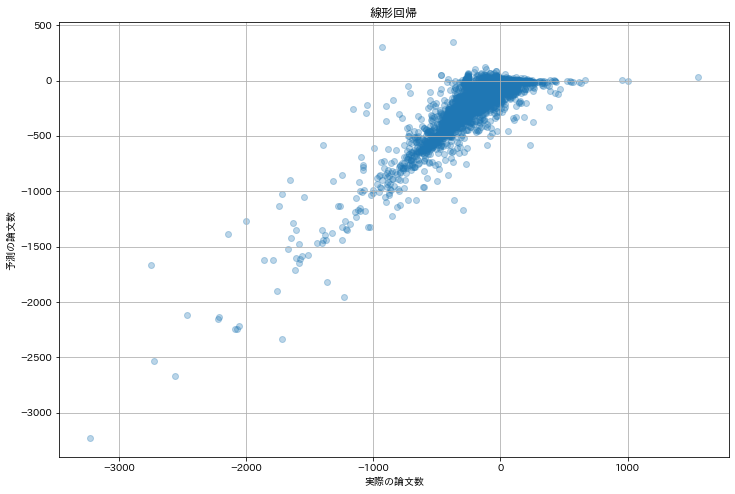

In [28]:
fig, ax = plt.subplots(facecolor="white",figsize=(12,8))
ax.scatter(test_y, result, alpha=0.3)
ax.set_xlabel("実際の論文数")
ax.set_ylabel("予測の論文数")
ax.grid()
ax.set_title("線形回帰")
fig.savefig(OUTPUTPATH+"img/lr_diff.png")
fig.show()

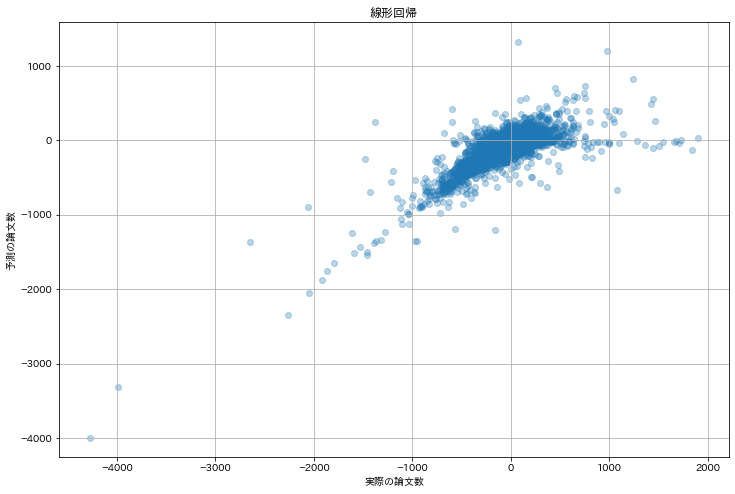

In [29]:
fig, ax = plt.subplots(facecolor="white",figsize=(12,8))
ax.scatter(train_y, result_before, alpha=0.3)
ax.set_xlabel("実際の論文数")
ax.set_ylabel("予測の論文数")
ax.grid()
ax.set_title("線形回帰")
# fig.savefig(OUTPUTPATH+"img/gbm.png")
fig.show()

In [30]:
predict_matrix = np.zeros([N,N]) 
correct_matrix = np.zeros([N,N]) 
correct_matrix[np.triu_indices(n=N, k=1)] = test_y
predict_matrix[np.triu_indices(n=N, k=1)] = model.predict(test_x)
for i in range(N):
    for j in range(N):
        if predict_matrix[i][j] < -2000:
            print("キーワード: {}, {}, 予測値: {}, 実測値: {}".format(keywords[i], keywords[j],round(predict_matrix[i][j],1), correct_matrix[i][j]))

キーワード: algorithm, bioinformatics, 予測値: -3223.3, 実測値: -3231.0
キーワード: algorithm, microarrays, 予測値: -2155.4, 実測値: -2223.0
キーワード: bioinformatics, biomedical research, 予測値: -2529.5, 実測値: -2723.0
キーワード: bioinformatics, microarrays, 予測値: -2139.1, 実測値: -2217.0
キーワード: feature extraction, image classification, 予測値: -2665.9, 実測値: -2556.0
キーワード: feature extraction, support vector machine, 予測値: -2334.7, 実測値: -1718.0
キーワード: field programmable gate array, fpga, 予測値: -2242.6, 実測値: -2088.0
キーワード: learning (artificial intelligence, machine learning, 予測値: -2220.4, 実測値: -2054.0
キーワード: mobile communications, mobile computing, 予測値: -2115.7, 実測値: -2464.0
キーワード: qos, quality of service, 予測値: -2246.8, 実測値: -2074.0


In [31]:
correct_new = correct_matrix[np.where(bool_matrix==0)]
predict_new = predict_matrix[np.where(bool_matrix==0)]
word_new = word_matrix[np.where(bool_matrix==0)]

In [32]:
df = pd.DataFrame(correct_new, columns=["実測値"])
df["予測値"] = predict_new
df["キーワード1"] = word_new[:,0]
df["キーワード2"] = word_new[:,1]
df.head()

,実測値,予測値,キーワード1,キーワード2
0,0.0,0.000000,3d imaging,3d imaging
1,0.0,-0.212418,3d imaging,a priori knowledge
2,0.0,1.483278,3d imaging,accelerometers
3,0.0,0.059451,3d imaging,access control
4,0.0,1.180546,3d imaging,access network


In [33]:
df.sort_values("予測値", ascending=False, inplace=True)
df.head(20)

,実測値,予測値,キーワード1,キーワード2
1384981,0.0,7.598045,graph g,optimisation
269275,0.0,7.484563,boundary value problem,data mining
687097,2.0,6.497961,data mining,frequency
509458,0.0,5.611231,computer science,frequency
92795,0.0,5.545709,application software,generic algorithm
93353,0.0,5.523386,application software,probability
2510708,0.0,5.464705,optimisation,space technology
93011,0.0,5.295597,application software,learning (artificial intelligenc
93094,0.0,5.289917,application software,measurement
93526,0.0,5.091671,application software,sensor


In [34]:
df.sort_values("実測値", ascending=False, inplace=True)
df.head(20)

,実測値,予測値,キーワード1,キーワード2
3703880,953.0,0.389565,task analysis,training
1740315,224.0,1.610069,internet of things,task analysis
744974,168.0,-0.182245,deconvolution,task analysis
741952,154.0,0.219232,decoding,task analysis
459010,149.0,2.048173,complexity theory,mimo communication
2163214,144.0,1.309030,mobile handsets,task analysis
77476,115.0,-0.315426,analytical models,task analysis
3035679,110.0,0.232986,remote sensing,task analysis
3538568,104.0,1.591638,standards,task analysis
459545,98.0,1.551091,complexity theory,task analysis


In [35]:
len(df)

4211183